# Centro de Investigación en Matemáticas
# Inteligencia Artificial
## Tarea 5. Predicción de profondidad por UNet
### José Miguel Saavedra Aguilar

Importamos los paquetes que utilizaremos

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
import tensorflow.keras as keras
import numpy as np
from skimage.transform import resize
import os
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="1";

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Definimos la VGG16 preentrenada en ImageNet.

In [2]:
conv_base=None
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))
conv_base.summary()

58889256/58889256 [==============================] - 8s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

Esta tarea se realizó en Colab con Docker y soporte para CUDA. No se corre directo en colab online con T100 porque limita la GPU

In [3]:
# Define paths for input and output directories
base_dir = '/data_depth_selection/depth_selection'
train_dir = os.path.join(base_dir, 'test_depth_completion_anonymous')
val_dir = os.path.join(base_dir, 'val_selection_cropped')

# Create ImageDataGenerator for input images with preprocessing function
input_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255.0)
# Create ImageDataGenerator for output images with resizing (if needed)
output_datagen = ImageDataGenerator(rescale=1./255.0)
# Define batch size
batch_size = 8

Debemos crear generadores auxiliares para tener la estructura deseada, input imagen rgb y output depth b/n.

In [4]:
image_train_generator = input_datagen.flow_from_directory(
    os.path.join(train_dir, 'image'),
    target_size=(224, 224),  # Assuming VGG16 input size
    batch_size=batch_size,
    shuffle    = False,
    class_mode=None  # Since this is an autoencoder, we don't need labels
)

depth_train_generator = output_datagen.flow_from_directory(
    os.path.join(train_dir, 'velodyne_raw'),
    target_size=(224, 224),  # Assuming VGG16 input size
    batch_size=batch_size,
    shuffle    = False,
    class_mode=None  # Since this is an autoencoder, we don't need labels
)

image_val_generator = input_datagen.flow_from_directory(
    os.path.join(val_dir, 'image'),
    target_size=(224, 224),  # Assuming VGG16 input size
    batch_size=batch_size,
    shuffle    = False,
    class_mode=None  # Since this is an autoencoder, we don't need labels
)

depth_val_generator = output_datagen.flow_from_directory(
    os.path.join(val_dir, 'velodyne_raw'),
    target_size=(224, 224),  # Assuming VGG16 input size
    batch_size=batch_size,
    shuffle    = False,
    class_mode=None  # Since this is an autoencoder, we don't need labels
)

# Custom generator to combine two generators into one

class JoinedGen(tf.keras.utils.Sequence):
    def __init__(self, input_gen1, input_gen2):
        self.gen1 = input_gen1
        self.gen2 = input_gen2
        assert len(input_gen1) == len(input_gen2), "Input generators must have the same length."
    def __len__(self):
        return min(len(self.gen1), len(self.gen2))
    def __getitem__(self, i):
        x = self.gen1.__getitem__(i)
        y = self.gen2.__getitem__(i)
        return x, y
    def on_epoch_end(self):
        if hasattr(self.gen1, 'on_epoch_end'):
            self.gen1.on_epoch_end()
        if hasattr(self.gen2, 'on_epoch_end'):
            self.gen2.on_epoch_end()


train_generator = JoinedGen(image_train_generator, depth_train_generator)
val_generator = JoinedGen(image_val_generator, depth_val_generator)

Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.


Fijamos ImageNet

In [5]:
conv_base.trainable = False

Creamos ahora nuestro autoencoder. Añadimos varias capas de convolución transpuestas, de upscaling y densas. La estructura de UNet lo dan las capas de concatenado entre capas del encoder y del decoder.

In [6]:

# Define input shape
input_shape = (224, 224, 3)  # Assuming input images have this shape

# Define input tensor
inputs = layers.Input(shape=input_shape)

# Encoder (using conv_base)
block1_conv1 = conv_base.get_layer('block1_conv1')(inputs)
block1_conv2 = conv_base.get_layer('block1_conv2')(block1_conv1)
block1_pool = conv_base.get_layer('block1_pool')(block1_conv2)
block2_conv1 = conv_base.get_layer('block2_conv1')(block1_pool)
block2_conv2 = conv_base.get_layer('block2_conv2')(block2_conv1)
block2_pool = conv_base.get_layer('block2_pool')(block2_conv2)
block3_conv1 = conv_base.get_layer('block3_conv1')(block2_pool)
block3_conv2 = conv_base.get_layer('block3_conv2')(block3_conv1)
block3_conv3 = conv_base.get_layer('block3_conv3')(block3_conv2)
block3_pool = conv_base.get_layer('block3_pool')(block3_conv3)
block4_conv1 = conv_base.get_layer('block4_conv1')(block3_pool)
block4_conv2 = conv_base.get_layer('block4_conv2')(block4_conv1)
block4_conv3 = conv_base.get_layer('block4_conv3')(block4_conv2)
block4_pool = conv_base.get_layer('block4_pool')(block4_conv3)
block5_conv1 = conv_base.get_layer('block5_conv1')(block4_pool)
block5_conv2 = conv_base.get_layer('block5_conv2')(block5_conv1)
block5_conv3 = conv_base.get_layer('block5_conv3')(block5_conv2)
block5_pool = conv_base.get_layer('block5_pool')(block5_conv3)

# Decoder
block6_conv1 = layers.Conv2DTranspose(512, (3, 3), activation='sigmoid', padding='same', name='block6_conv1')(block5_pool)
block6_upsamp = layers.UpSampling2D((4, 4),name='block6_upsamp')(block6_conv1)
block7_concat = layers.Concatenate(name='block7_concat')([block6_upsamp, block4_conv3])
block7_conv1 = layers.Conv2DTranspose(128, (3, 3), activation='sigmoid', padding='same',name='block7_conv1')(block7_concat)
block7_conv2 = layers.Conv2DTranspose(128, (3, 3), activation='sigmoid', padding='same',name='block7_conv2')(block7_conv1)
block7_upsamp = layers.UpSampling2D((4, 4),name='block7_upsamp')(block7_conv2)
block8_concat = layers.Concatenate(name='block8_concat')([block7_upsamp, block2_conv2])
block8_conv1 = layers.Conv2DTranspose(32, (3, 3), activation='sigmoid', padding='same',name='block8_conv1')(block8_concat)
block8_upsamp = layers.UpSampling2D((2, 2),name='block8_upsamp')(block8_conv1)
decoded_output = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same',name='decoded_output')(block8_upsamp)  # Output image has 3 channels (RGB)

# Create autoencoder model
autoencoder = models.Model(inputs, decoded_output)


Utilizo la función de costo SSIM como en la tarea 4, que debe comparar las características de ambas imágenes.

In [20]:
# Define SSIM loss
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=255.0))

# Compile the model with SSIM loss
autoencoder.compile(optimizer='adam', loss = [ssim_loss])

# Print summary
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[1][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[1][0]']        
                                                                                              

Entrenamos con 20 épocas. Lo hice hasta por 50 y no mejora demasiado, a partir de 25 es casi fijo. Finalmente guardamos para poder extraer el modelo y cargarlo después si fuera necesario.

In [8]:
num_epochs = 20

# Train the autoencoder
steps_per_epoch = len(train_generator) # Number of batches per epoch
validation_steps = len(val_generator)  # Number of batches for validation

autoencoder.fit(train_generator,
                steps_per_epoch=steps_per_epoch,
                epochs=num_epochs,
                validation_data=val_generator,
                validation_steps=validation_steps)

# Save the trained model
autoencoder.save('/unetautoencoder.keras')

Epoch 1/20
125/125 [==============================] - 60s 322ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 2/20
125/125 [==============================] - 41s 326ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3/20
125/125 [==============================] - 40s 322ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/20
125/125 [==============================] - 40s 318ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/20
125/125 [==============================] - 40s 320ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/20
125/125 [==============================] - 40s 320ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/20
125/125 [==============================] - 40s 318ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/20
125/125 [==============================] - 40s 318ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/20
125/125 [==============================] - 40s 319ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 10/20
125/125 [==============================] - 44s 351ms/step - l

Ahora, vemos si la red aprendió lo que queremos. Tomamos una imagen del conjunto de validación y la pasamos por la red.

1/1 [==============================] - 2s 2s/step


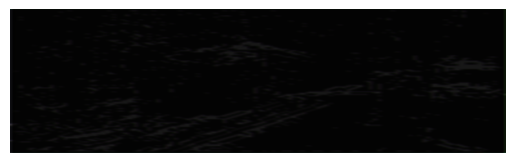

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

# Load a sample image
sample_image_path = '/data_depth_selection/depth_selection/val_selection_cropped/image/1/2011_09_26_drive_0005_sync_image_0000000092_image_02.png'
sample_image = Image.open(sample_image_path)
sample_image = sample_image.resize((224, 224))  # Resize to match model input size
sample_image_array = np.array(sample_image)

# Preprocess the sample image using input_datagen
preprocessed_sample_image = preprocess_input(sample_image_array)

# Expand dimensions to match model input shape
preprocessed_sample_image = np.expand_dims(preprocessed_sample_image, axis=0)

# Predict using the autoencoder model
predicted_output = autoencoder.predict(preprocessed_sample_image)

# Denormalize the output (if needed)
predicted_output = np.clip(predicted_output * 255.0, 0, 255).astype(np.uint8)

# Convert the predicted output to an image

predicted_output_image = Image.fromarray(predicted_output[0]).resize((1216,352))

predicted_output_image.save("/predicted_output.png")

predicted_output_image.resize((38,11))

# Display the predicted output image
plt.imshow(predicted_output_image)
plt.axis('off')  # Hide axes
plt.show()

Ahora, descongelamos la última capa para hacer el ajuste fino.

In [10]:
autoencoder.layers[15].trainable = True
autoencoder.layers[16].trainable = True
autoencoder.layers[17].trainable = True
autoencoder.layers[18].trainable = True
autoencoder.compile(optimizer='adam', loss = [ssim_loss])

# Print summary
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[1][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[1][0]']        
                                                                                              

In [11]:
num_epochs = 20

autoencoder.fit(train_generator,
                steps_per_epoch=steps_per_epoch,
                epochs=num_epochs,
                validation_data=val_generator,
                validation_steps=validation_steps)

# Save the trained model
autoencoder.save('/unetautoencoderunfrozen.keras')

Epoch 1/20
125/125 [==============================] - 44s 325ms/step - loss: 0.0010 - val_loss: 9.8158e-04
Epoch 2/20
125/125 [==============================] - 40s 321ms/step - loss: 9.8637e-04 - val_loss: 9.7919e-04
Epoch 3/20
125/125 [==============================] - 40s 323ms/step - loss: 9.8282e-04 - val_loss: 9.7615e-04
Epoch 4/20
125/125 [==============================] - 40s 320ms/step - loss: 9.8104e-04 - val_loss: 9.7532e-04
Epoch 5/20
125/125 [==============================] - 40s 322ms/step - loss: 9.7801e-04 - val_loss: 9.7383e-04
Epoch 6/20
125/125 [==============================] - 41s 326ms/step - loss: 9.7695e-04 - val_loss: 9.7719e-04
Epoch 7/20
125/125 [==============================] - 40s 320ms/step - loss: 9.7866e-04 - val_loss: 9.7282e-04
Epoch 8/20
125/125 [==============================] - 40s 321ms/step - loss: 9.7377e-04 - val_loss: 9.7367e-04
Epoch 9/20
125/125 [==============================] - 40s 323ms/step - loss: 9.7244e-04 - val_loss: 9.7597e-04
Epoch

Ahora vemos que tal salió la predicción con ajuste fino.

1/1 [==============================] - 0s 19ms/step


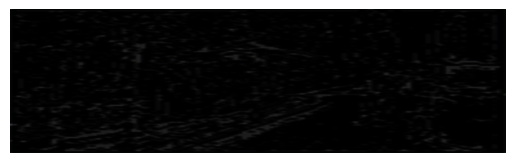

In [14]:
# Predict using the autoencoder model
predicted_output = autoencoder.predict(preprocessed_sample_image)

# Denormalize the output (if needed)
predicted_output_unfrozen = np.clip(predicted_output * 255.0, 0, 255).astype(np.uint8)

# Convert the predicted output to an image
predicted_output_image_unfrozen = Image.fromarray(predicted_output_unfrozen[0]).resize((1216,352))

# Save the predicted output image
predicted_output_image_unfrozen.save("/predicted_output_unfrozen.png")

predicted_output_image_unfrozen.resize((38,11))

# Display the predicted output image
plt.imshow(predicted_output_image_unfrozen)
plt.axis('off')  # Hide axes
plt.show()

Finalmente, ajuste completo, entrenamos la red completa.

In [15]:
for i in range(15):
  autoencoder.layers[i].trainable = True

autoencoder.compile(optimizer='adam', loss = [ssim_loss])

# Print summary
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[1][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[1][0]']        
                                                                                              

In [16]:
num_epochs = 20

autoencoder.fit(train_generator,
                steps_per_epoch=steps_per_epoch,
                epochs=num_epochs,
                validation_data=val_generator,
                validation_steps=validation_steps)

# Save the trained model
autoencoder.save('/unetautoencoderfull.keras')

Epoch 1/20
125/125 [==============================] - 50s 331ms/step - loss: 0.0010 - val_loss: 9.7904e-04
Epoch 2/20
125/125 [==============================] - 41s 328ms/step - loss: 9.8476e-04 - val_loss: 9.7148e-04
Epoch 3/20
125/125 [==============================] - 41s 328ms/step - loss: 9.7798e-04 - val_loss: 9.6771e-04
Epoch 4/20
125/125 [==============================] - 41s 329ms/step - loss: 9.7431e-04 - val_loss: 9.6432e-04
Epoch 5/20
125/125 [==============================] - 41s 329ms/step - loss: 9.7128e-04 - val_loss: 9.6309e-04
Epoch 6/20
125/125 [==============================] - 41s 329ms/step - loss: 9.6887e-04 - val_loss: 9.6431e-04
Epoch 7/20
125/125 [==============================] - 42s 334ms/step - loss: 9.6748e-04 - val_loss: 9.6300e-04
Epoch 8/20
125/125 [==============================] - 41s 330ms/step - loss: 9.6486e-04 - val_loss: 9.6154e-04
Epoch 9/20
125/125 [==============================] - 42s 332ms/step - loss: 9.6285e-04 - val_loss: 9.6285e-04
Epoch

1/1 [==============================] - 0s 224ms/step


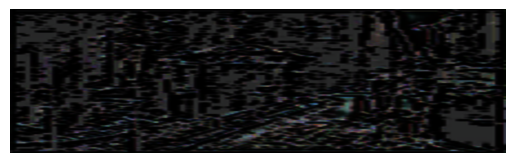

In [17]:
# Predict using the autoencoder model
predicted_output = autoencoder.predict(preprocessed_sample_image)

# Denormalize the output (if needed)
predicted_output_full = np.clip(predicted_output * 255.0, 0, 255).astype(np.uint8)

# Convert the predicted output to an image
predicted_output_image_full = Image.fromarray(predicted_output_full[0]).resize((1216,352))

# Save the predicted output image
predicted_output_image_full.save("/predicted_output_full.png")

predicted_output_image_full.resize((38,11))

# Display the predicted output image
plt.imshow(predicted_output_image_full)
plt.axis('off')  # Hide axes
plt.show()

Finalmente, presentamos un comparativo entre las imágenes estimadas con la verdadera. Vemos que no hay gran diferencia entre el decoder únicamente y el ajuste fino. La red con ajuste completo resalta más detalles de la imagen. En general, todas son muy parecidas.

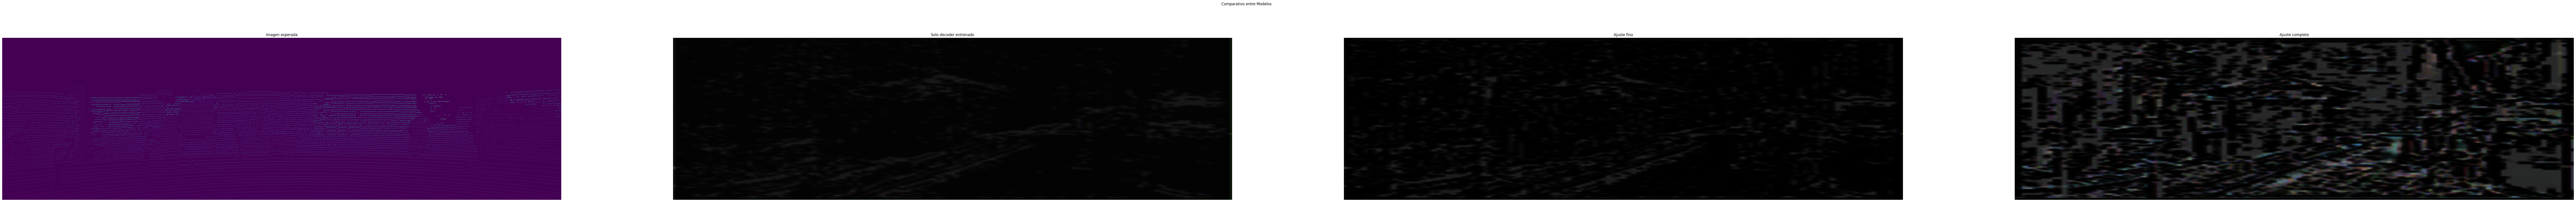

In [24]:
from matplotlib import image

# Load the image
true_image = image.imread('/data_depth_selection/depth_selection/val_selection_cropped/velodyne_raw/1/2011_09_26_drive_0005_sync_velodyne_raw_0000000092_image_02.png')

# Create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 4, figsize=(152, 11))

axs[0].imshow(true_image)
axs[0].set_title("Imagen esperada")

# Plot each image on its corresponding subplot
axs[1].imshow(predicted_output_image)
axs[1].set_title("Solo decoder entrenado")

axs[2].imshow(predicted_output_image_unfrozen)
axs[2].set_title("Ajuste fino")

axs[3].imshow(predicted_output_image_full)
axs[3].set_title("Ajuste completo")

# Hide axes ticks and labels
for ax in axs:
    ax.axis("off")

# Add a common title for the entire figure
fig.suptitle("Comparativo entre Modelos")

# Show the plot
plt.show()
